# Focus on WBF in mixed-phase clouds

Looking at the WBF process impact on masses and dependency on temperature (as a height proxy)

Contains figure 03 and 04. Additional figures are given at the bottom.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import xarray as xr 
import matplotlib.gridspec as gridspec

from scipy.stats import levene
from scipy.stats import kruskal


import sys
sys.path.append('../required_modules/')
from process_class import Process

## 1. Data

In [32]:
# get data
fig_path='../figures/'
data_path = '/data/'
# for fig. 3
df_mpc = pd.read_csv(data_path+'processed/df_all_tends_mpc_pn_and_pd_v2.csv')

# for fig. 4
ds_pn_pd = xr.open_dataset(data_path+'processed/nc_files_revisions/df_all_tends_mpc_pn_and_pd_v1.nc')
# polar night and polar day selection
ds_pn = ds_pn_pd.sel(time=ds_pn_pd.time.dt.month.isin([11, 12, 1, 2]))
ds_pd = ds_pn_pd.sel(time=ds_pn_pd.time.dt.month.isin([5, 6, 7, 8,]))

Get number of PN and PD cases 

In [33]:
# compute total number of timesteps in the dataset
# 1 timestep = 9 seconds
tsinminutes = 60/9
print('pn mpc days: {:.2f}'.format( ds_pn.time.shape[0]/tsinminutes/60/24))
print('pd mpc days: {:.2f}'.format( ds_pd.time.shape[0]/tsinminutes/60/24))
print('pn and pd mpc days: {:.2f}'.format( ds_pn_pd.time.shape[0]/tsinminutes/60/24))

pn mpc days: 14.10
pd mpc days: 9.69
pn and pd mpc days: 23.79


Create subselection for WBF cases

In [20]:
# split df_mpc into two dataframes with one for cases where evaporation is happening and no deposition 
# and one where evaporation and deposition is happening

df_mpc_evap_nodep = df_mpc[(df_mpc["evaporation_li"] > 1e-18) & (df_mpc["deposition_fr"] < 1e-22)]
df_mpc_evap_dep = df_mpc[(df_mpc["evaporation_li"] > 1e-18) & (df_mpc["deposition_fr"] > 1e-18)]

# do same for deposition and no evaporation
df_mpc_dep_noevap = df_mpc[(df_mpc["evaporation_li"] < 1e-22) & (df_mpc["deposition_fr"] > 1e-18)]


In [22]:
# select all rows where all processes are smaller than 10^-18 and drop them.
# Avoid using the columns QI,...liquid_mass,... as they are not processes
proc_list_sel = ["deposition_fr", "sublimation_fr", "fr_eva_fr", "melt_fr", 
                 "rime_fr", "r_freeze_fr" , "evaporation_li", "condensation_li"]
df_mpc_sel = df_mpc[(df_mpc[proc_list_sel] < 10**-18).all(axis=1)]
df_mpc = df_mpc.drop(df_mpc_sel.index)

## 2.  Can we see the WBF process?
Use distributions to see if it makes a statistical difference.

### 2.1 Figure 3 

In [13]:
mass_bins = np.arange(-8,-3, 0.1)

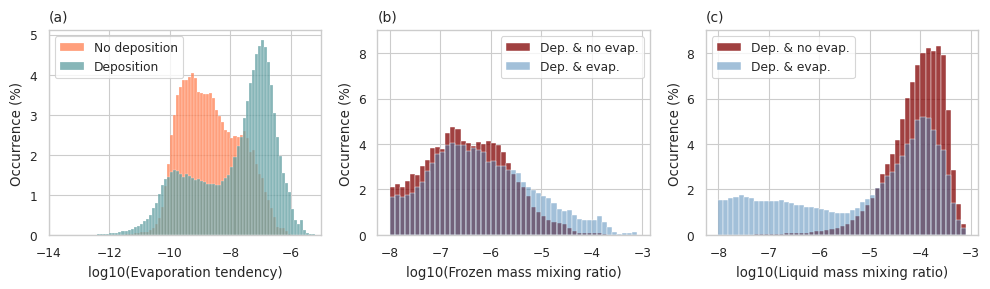

In [24]:
sns.set_context("paper")

# make similar plot as above but make two subplots for evaporation and deposition
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
sns.histplot(np.log10(df_mpc_evap_nodep["evaporation_li"]), bins=np.arange(-14,-5, 0.1),
              color="coral", 
             label="No deposition", stat="percent", ax=ax[0])
sns.histplot(np.log10(df_mpc_evap_dep["evaporation_li"]), bins=np.arange(-14,-5, 0.1),
              color="cadetblue",
              label="Deposition", stat="percent", ax=ax[0])
ax[0].set_xlabel("log10(Evaporation tendency)")
ax[0].set_xlim(-14, -5)
ax[0].set_ylabel("Occurrence (%)")
ax[0].legend()

sns.histplot(np.log10(df_mpc_dep_noevap["frozen mass"]), bins=mass_bins, 
             color="maroon",
                label="Dep. & no evap.", stat="percent", ax=ax[1])
sns.histplot(np.log10(df_mpc_evap_dep["frozen mass"]), bins=mass_bins, 
             color="steelblue",
                label="Dep. & evap.", stat="percent", ax=ax[1], alpha=0.5) 
ax[1].set_xlabel("log10(Frozen mass mixing ratio)")
ax[1].set_ylabel("Occurrence (%)")
ax[1].set_ylim(0,9)
# only write every second y tick label
ax[1].set_yticks(ax[1].get_yticks()[::2])
ax[1].legend()

sns.histplot(np.log10(df_mpc_dep_noevap["liquid mass"]), bins=mass_bins, 
             color="maroon",
                label="Dep. & no evap.", stat="percent", ax=ax[2])
sns.histplot(np.log10(df_mpc_evap_dep["liquid mass"]), bins=mass_bins, 
             color="steelblue",
                label="Dep. & evap.", stat="percent", ax=ax[2], alpha=0.5) 
ax[2].set_xlabel("log10(Liquid mass mixing ratio)")
ax[2].set_ylabel("Occurrence (%)")
ax[2].set_ylim(0,9)
# write only every second y tick label
ax[2].set_yticks(ax[2].get_yticks()[::2])
ax[2].legend()

# add letters to subplots (a), (b), (c)
ax[0].text(0., 1.05, '(a)', transform=ax[0].transAxes, size=10)
ax[1].text(0., 1.05, '(b)', transform=ax[1].transAxes, size=10)
ax[2].text(0., 1.05, '(c)', transform=ax[2].transAxes, size=10)

plt.savefig(fig_path + "fig03_evap_dep_histograms_revised.pdf", bbox_inches='tight', )
plt.tight_layout()
plt.show()

Number of cases per set in percent of total number of cases

In [25]:
print(df_mpc_evap_dep["evaporation_li"].count()/df_mpc["deposition_fr"].count())
print(df_mpc_evap_nodep["evaporation_li"].count()/df_mpc["deposition_fr"].count())
print(df_mpc_dep_noevap["deposition_fr"].count()/df_mpc["deposition_fr"].count())

0.4180677562582002
0.3333246444056339
0.24678485539210718


### 2.2 Statistics

In [8]:
# run a significance test to see if the two distributions are significantly different
# 1. check if variance is equal
# 2. if variance is equal, run a t-test
# 3. if variance is not equal, run kruskal-wallis test

# 1. check if variance is equal
levene(df_mpc_evap_nodep["evaporation_li"], df_mpc_evap_dep["evaporation_li"])
# p-value is 0.0, so variance is not equal

# 2. if variance is not equal, run kruskal-wallis test
stat, p = kruskal(df_mpc_evap_nodep["evaporation_li"], df_mpc_evap_dep["evaporation_li"])
# p-value is 0.0, so distributions are significantly different (at 95% confidence level)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=242044.314, p=0.000
Probably different distributions


In [9]:
# do same for deposition
levene(df_mpc_dep_noevap["deposition_fr"], df_mpc_evap_dep["deposition_fr"])
# p-value is 0.0, so variance is not equal

# 2. if variance is not equal, run kruskal-wallis test
stat, p = kruskal(df_mpc_dep_noevap["deposition_fr"], df_mpc_evap_dep["deposition_fr"])
# p-value is 0.0, so distributions are significantly different (at 95% confidence level)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')


stat=2623.836, p=0.000
Probably different distributions


## 3. WBF with temperature

In [35]:
WBF = Process(ds_pn_pd.wbf)
Deposition = Process(ds_pn_pd.deposition_fr)
Evaporation = Process(ds_pn_pd.evaporation_li)
Riming = Process(ds_pn_pd.rime_fr)
Freezing_rain = Process(ds_pn_pd.r_freeze_fr)

FrozenMass = Process(ds_pn_pd.frozen_mass, threshold=1e-8)

Use method get_normtemp_freq() to get values for total, PN, PD

In [38]:
# Bin WBF by temperature (T) and plot the frequency of WBF as a function of T
T_bins = np.arange(-40, 5, 1)
T_center = (T_bins[:-1] + T_bins[1:]) / 2

dep_normtemp = Deposition.get_normtemp_freq(ds_pn_pd.T, T_bins)
wbf_normtemp = WBF.get_normtemp_freq(ds_pn_pd.T, T_bins)
evap_normtemp = Evaporation.get_normtemp_freq(ds_pn_pd.T, T_bins)
riming_normtemp = Riming.get_normtemp_freq(ds_pn_pd.T, T_bins)
frrain_normtemp = Freezing_rain.get_normtemp_freq(ds_pn_pd.T, T_bins)

# only frozen mass needed because MPC so liquid by definition above thold
cloud_normtemp = FrozenMass.get_normtemp_freq(ds_pn_pd.T, T_bins)

0 PN
1 PN
2 PD
3 PD


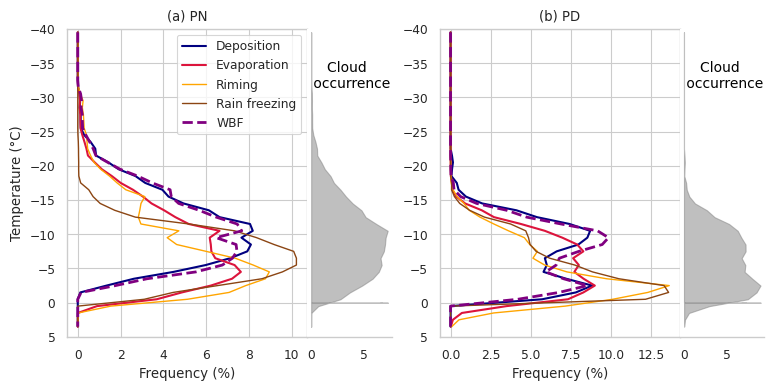

In [40]:
sns.set_style('whitegrid')
sns.set_context('paper')

# Create a GridSpec with 1 row and 4 columns
gs = gridspec.GridSpec(1, 5, width_ratios=[2, 0.7,0.4, 2, 0.7])  

fig = plt.figure(figsize=(9, 4))
plt.subplots_adjust(wspace=0) 

ax1 = plt.subplot(gs[0])  # First subplot
ax2 = plt.subplot(gs[1])  # Second subplot
ax_spacer = plt.subplot(gs[2])  # Spacer
ax3 = plt.subplot(gs[3])  # Third subplot
ax4 = plt.subplot(gs[4])  # fourth subplot
ax_spacer.axis('off')

axs = [ax1, ax2, ax3, ax4]

label_list = ['(a) PN', '(b) PD']
key_list = ['PN', 'PD']
for k in range(4):
    key = key_list[k//2]
    print(k, key)
    if k%2 == 0:
        axs[k].plot(dep_normtemp[key], 
                T_center, linewidth=1.5, color='navy', label='Deposition')
        axs[k].plot(evap_normtemp[key], T_center, linewidth=1.5,
                        label='Evaporation',color='crimson')
        axs[k].plot(riming_normtemp[key], T_center, linewidth=1,
                    label='Riming', linestyle='-', color='orange')
        axs[k].plot(frrain_normtemp[key], T_center, linewidth=1,
                    label='Rain freezing', linestyle='-', color='saddlebrown')
        axs[k].plot(wbf_normtemp[key], T_center, 
                    label='WBF', linewidth=2, color='purple', linestyle='--')
        axs[k].set_xlabel('Frequency (%)')
    if k%2 != 0:
        axs[k].set_yticklabels([])
        axs[k].fill_between(cloud_normtemp[key], T_center,
                    label='Cloud', linestyle='-', color='grey', alpha=0.5)
        # no grid
        axs[k].grid(False)
        # no border box on any side
        axs[k].spines['top'].set_visible(False)
        axs[k].spines['right'].set_visible(False)
        #axs[k].spines['bottom'].set_visible(False)
        axs[k].spines['left'].set_visible(False)
        # set ticks for x-axis and make them visible
        axs[k].set_xticks([0,5])
        #axs[k].tick_params(axis='x', which='both', bottom=True)
        # add text in the plot which says "cloud occurrence". use fontsize 12
        axs[k].text(0.5, 0.8, 'Cloud \n occurrence', fontsize=10, color='black',
            verticalalignment='bottom', horizontalalignment='center',
            transform=axs[k].transAxes)
        

axs[0].set_title(label_list[0])

axs[2].set_title(label_list[1])

for k in range(4):
    axs[k].invert_yaxis()
    axs[k].set_ylim(5,-40)

axs[0].legend()

axs[0].set_ylabel('Temperature (°C)')

plt.savefig(fig_path+'fig04_wbf_procs_freq_temp.pdf', bbox_inches='tight')


## Appendix
### A1: Mass of evaporation and deposition

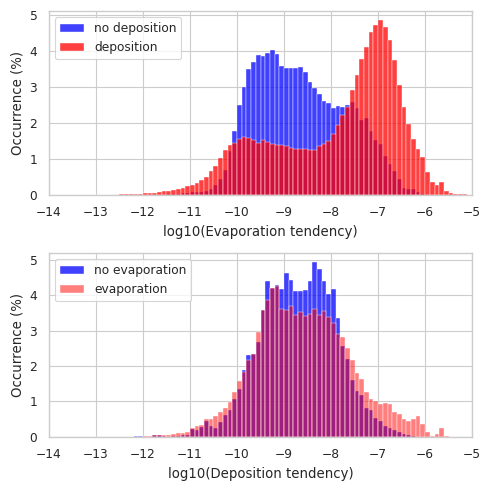

In [26]:
sns.set_style("whitegrid")

# make similar plot as above but make two subplots for evaporation and deposition
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,5))
sns.histplot(np.log10(df_mpc_evap_nodep["evaporation_li"]), bins=np.arange(-14,-5, 0.1), 
             color="blue", label="no deposition", stat="percent", ax=ax[0])
sns.histplot(np.log10(df_mpc_evap_dep["evaporation_li"]), bins=np.arange(-14,-5, 0.1), 
             color="red", label="deposition", stat="percent", ax=ax[0])
ax[0].set_xlabel("log10(Evaporation tendency)")
ax[0].set_xlim(-14, -5)
ax[0].set_ylabel("Occurrence (%)")
ax[0].legend()

sns.histplot(np.log10(df_mpc_dep_noevap["deposition_fr"]), bins=np.arange(-14,-5, 0.1),
              color="blue", label="no evaporation", stat="percent", ax=ax[1])   
sns.histplot(np.log10(df_mpc_evap_dep["deposition_fr"]), bins=np.arange(-14,-5, 0.1),
              color="red", label="evaporation", stat="percent", ax=ax[1], alpha=0.5)
ax[1].set_xlabel("log10(Deposition tendency)")
ax[1].set_xlim(-14, -5)
ax[1].set_ylabel("Occurrence (%)")
ax[1].legend()
plt.tight_layout()
plt.show()


What one can see is that if evaporation and deposition happen at the same time then the evaporation mass will increase significantly but the deposition mass will not increase as much.
The bi-modal distribution is interesting.

Check the connection of the frozen mass and the liquid mass

/home/tkiszler/sw/miniconda3/envs/python3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tkiszler/sw/miniconda3/envs/python3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


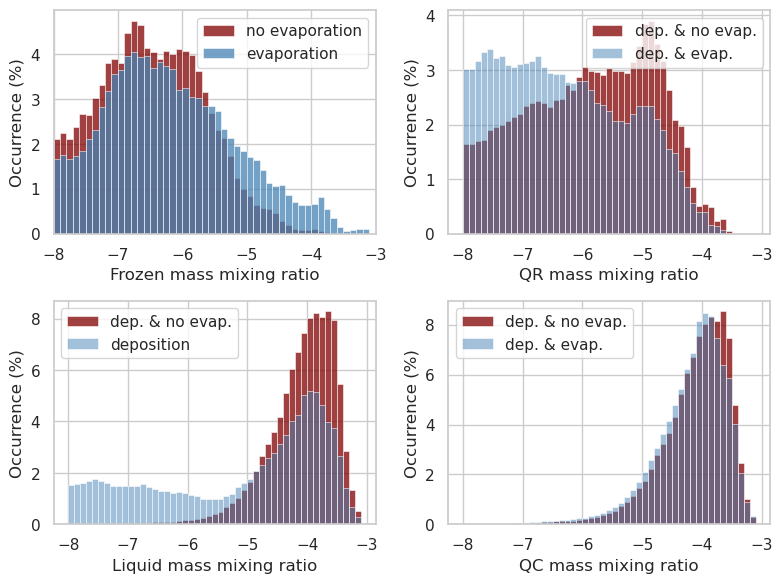

In [30]:
# make similar plot as above but make two subplots for evaporation and deposition
sns.set_theme(style="whitegrid")
mass_bins = np.arange(-8,-3, 0.1)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
sns.histplot(np.log10(df_mpc_dep_noevap["frozen mass"]), bins=mass_bins, color="maroon", 
             label="no evaporation", stat="percent", ax=ax[0,0])
sns.histplot(np.log10(df_mpc_evap_dep["frozen mass"]), bins=mass_bins, color="steelblue",
              label="evaporation", stat="percent", ax=ax[0,0])
ax[0,0].set_xlabel("Frozen mass mixing ratio")
ax[0,0].set_xlim(-8, -3)
ax[0,0].set_ylabel("Occurrence (%)")
ax[0,0].legend()

sns.histplot(np.log10(df_mpc_dep_noevap["liquid mass"]), bins=mass_bins, color="maroon",
                label="dep. & no evap.", stat="percent", ax=ax[1,0])   
sns.histplot(np.log10(df_mpc_evap_dep["liquid mass"]), bins=mass_bins, color="steelblue",
                label="deposition", stat="percent", ax=ax[1,0], alpha=0.5)
ax[1,0].set_xlabel("Liquid mass mixing ratio")
#ax[1].set_xlim(-14, -5)
ax[1,0].set_ylabel("Occurrence (%)")
ax[1,0].legend()

sns.histplot(np.log10(df_mpc_dep_noevap["QR"]), bins=mass_bins, color="maroon",
                label="dep. & no evap.", stat="percent", ax=ax[0,1])
sns.histplot(np.log10(df_mpc_evap_dep["QR"]), bins=mass_bins, color="steelblue",
                label="dep. & evap.", stat="percent", ax=ax[0,1], alpha=0.5) 
ax[0,1].set_xlabel("QR mass mixing ratio")
ax[0,1].set_ylabel("Occurrence (%)")
ax[0,1].legend()

sns.histplot(np.log10(df_mpc_dep_noevap["QC"]), bins=mass_bins, color="maroon",
                label="dep. & no evap.", stat="percent", ax=ax[1,1])
sns.histplot(np.log10(df_mpc_evap_dep["QC"]), bins=mass_bins, color="steelblue",
                label="dep. & evap.", stat="percent", ax=ax[1,1], alpha=0.5) 
ax[1,1].set_xlabel("QC mass mixing ratio")
ax[1,1].set_ylabel("Occurrence (%)")
ax[1,1].legend()

plt.tight_layout()
plt.show()

We can now quantify the sum of how much the frozen mass is higher when evaporation is given than when it is not given.

In [29]:
print(df_mpc_dep_noevap["frozen mass"].sum() - df_mpc_evap_dep["frozen mass"].sum()) # 16.97 kg/kg 

print(df_mpc_evap_dep["evaporation_li"].sum() - df_mpc_evap_nodep["evaporation_li"].sum())

print(df_mpc_evap_dep["deposition_fr"].sum() - df_mpc_dep_noevap["deposition_fr"].sum())
#df_mpc_li_mass_nodep["liquid mass"].sum() - df_mpc_li_mass_dep["liquid mass"].sum()

-11.845601022139158
0.14821621199184598
0.04277763941953243


So the frozen mass is in sum 11.65 kg/kg higher if evaporation is happening. 

The sum of evaporated liquid is higher when deposition is occurring. 

The sum of deposition is higher when evaporation is occuring. 